## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [6]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [3]:
#Understand the data
df=train_data
df.describe()


,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [8]:
#Check for missing values
df.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [9]:
#Find the no of customers who purchased without promotion and with promotion
df.groupby(['Promotion','purchase'])['ID'].count()

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: ID, dtype: int64

In [10]:
#No. of observations in the experiment group
n_control=df.query('Promotion=="No"').count()[0]

In [11]:
#The rate of purchase made by the customers who received promotion
(df.query('Promotion=="Yes" and purchase==1').count()[0]/df.query('Promotion=="Yes"').count())[0]

0.017019167217448776

In [12]:
#The rate of purchase made by customers who did not receive promotion
(df.query('Promotion=="No" and purchase==1').count()[0]/df.query('Promotion=="No"').count())[0]

0.0075646193976760734

### Analyse Data
### Invariant Metric
### Null Hypothesis H0: No.ofCustomers-Control = No.ofCustomers-Experiment group
### Alternative Hypothesis H1: No.ofCustomers-Control not equal to  No.ofCustomers-Experiment group



In [13]:

n=df.shape[0]
p_null=0.5
sd=np.sqrt(p_null*(1-p_null)*n)
z_score=((n_control+0.5)-p_null*n)/sd
p_value=2 * stats.norm.cdf(z_score)
p_value


0.50681406854190458

### The p-value is 0.50 which is greater than alpha value 0.05. Hence, Failed to reject the null hypothesis
### BootStrapping

In [14]:
size=df.shape[0]
diffs=[]
for _ in range(10000):
    samp=df.sample(size,replace=True)
    promo_y=samp.query('Promotion=="Yes"').count()[0]
    promo_n=samp.query('Promotion=="No"').count()[0]
    diffs.append(promo_n-promo_y)


(array([   28.,   168.,   712.,  1780.,  2792.,  2593.,  1395.,   435.,
           87.,    10.]),
 array([-1238., -1022.,  -806.,  -590.,  -374.,  -158.,    58.,   274.,
          490.,   706.,   922.]),
 <a list of 10 Patch objects>)

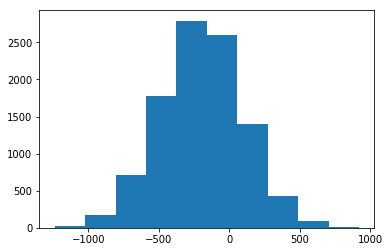

In [15]:
plt.hist(diffs)
#plt.axvline(diffs,c='red')

In [16]:
m=np.array(diffs).mean()
null_mean=df.query('Promotion=="No"').shape[0]
alt_mean=df.query('Promotion=="Yes"').shape[0]

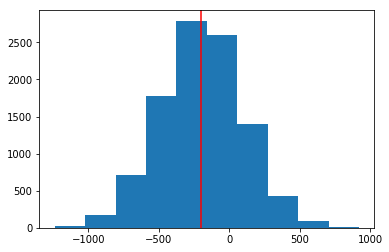

In [17]:
plt.hist(diffs)
plt.axvline(x=m,c='red')

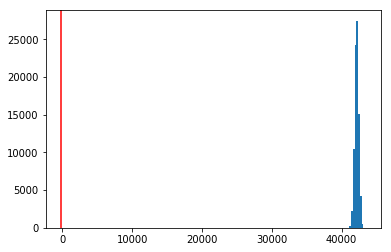

In [18]:
null_vals=np.random.normal(null_mean,np.std(diffs),size)
plt.hist(null_vals)
plt.axvline(x=m,c='red')

In [19]:
z=(null_mean-alt_mean)/np.std(diffs)
pv=2*stats.norm.cdf(z)
pv

0.50855391807364714

### The p value is 0.50 which is greater than the alpha value 0.05. Hence we fail to reject the null hypothesis.

### Calculate Evaluation Metrics
### The evaluation metrics are Increment Response Rate IRR and Net Incremental Revenue NIR

### Evaluation Metric 1: 
### IRR = purch(exp)/No.Of.Customers(exp) -  purch(control)/No.Of.Customers(control)
### Hypothesis Testing Ho: IRR=0 H1:IRR>0


In [20]:
# Calculate the IRR value
p_exp=df.query('Promotion=="Yes" and purchase==1').count()[0]
n_exp=df.query('Promotion=="Yes"').count()[0]
p_control=df.query('Promotion=="No" and purchase==1').count()[0]
n_exp=df.query('Promotion=="No"').count()[0]
IRR=p_exp/n_exp - p_control/n_exp
IRR

0.0095328432534977463

In [21]:
alt_mean =p_exp/n_exp
null_mean=p_control/n_control

### BootStrapping
### Sampling is done with replacement and the normal distribution is obtained
### The Bonferroni correction is used to reduce the chances of obtaining false-positive results (type I errors) when multiple pair wise tests are performed on a single set of data. 
### Hence Bonferroni correction is applied and the alpha value = alpha/(no. of metrics)
### alpha=0.05/2 = 0.025

In [22]:
diff_irr=[]
for _ in range(10000):
    samp=df.sample(size,replace=True)
    p_exp=samp.query('Promotion=="Yes" and purchase==1').count()[0]
    n_exp=samp.query('Promotion=="Yes"').count()[0]
    p_control=samp.query('Promotion=="No" and purchase==1').count()[0]
    n_exp=samp.query('Promotion=="No"').count()[0]
    IRR=p_exp/n_exp - p_control/n_exp
    diff_irr.append(IRR)


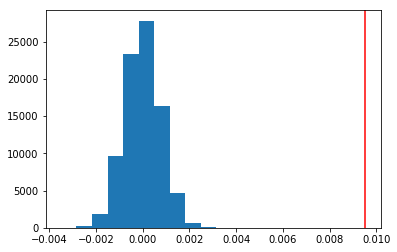

In [23]:
nor=np.random.normal(0,np.std(diff_irr),size)
plt.hist(nor)
plt.axvline(np.array(diff_irr).mean(),c='red')

In [24]:
z=(null_mean-alt_mean)/np.std(diff_irr)
p_val=1-stats.norm.cdf(np.array(diff_irr).mean(),0,np.std(diff_irr))
p_val

0.0

### The p  value is 0.0 which is less than the alpha value 0.025. Hence we reject the null hypothesis. Hence IRR value is greater than 0.

### Evaluation Metric II 
### Net Incremental Revenue (NIR) : NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.
### NIR = 10*Customer(experiment) - 0.15*promotions - 10*customers(control)
### Hypothesis Testing Ho: NIR=0 H1:NIR>0

In [25]:
# Calculate NIR value
cust_exp=df.query('Promotion=="Yes" and purchase == 1').count()[0]
cust_control=df.query('Promotion=="No" and purchase == 1').count()[0]
no_prom=df.query('Promotion=="Yes"').count()[0]
NIR=10*cust_exp - 0.15 * no_prom -10*cust_control
NIR

-2334.5999999999995

### BootStrapping

In [26]:
# Sampling with replacement
diff_nir=[]
for _ in range(10000):
    samp=df.sample(size,replace=True)
    cust_exp=df.query('Promotion=="Yes" and purchase == 1').count()[0]
    cust_control=df.query('Promotion=="No" and purchase == 1').count()[0]
    no_prom=df.query('Promotion=="Yes"').count()[0]
    NIR=10*cust_exp - 0.15 * no_prom -10*cust_control
    diff_nir.append(NIR)

(array([   2.,    0.,    1.,    4.,    2.,    3.,    5.,    9.,   11.,
          16.,   17.,   25.,   32.,   45.,   66.,   85.,   95.,  166.,
         188.,  215.,  240.,  299.,  333.,  361.,  442.,  450.,  443.,
         489.,  498.,  509.,  536.,  488.,  505.,  466.,  472.,  404.,
         376.,  283.,  273.,  235.,  187.,  168.,  134.,  107.,   73.,
          59.,   54.,   35.,   24.,   16.,   17.,   15.,    4.,    6.,
           5.,    3.,    2.,    0.,    1.,    1.]),
 array([ -1.76046121e-12,  -1.70157809e-12,  -1.64269497e-12,
         -1.58381185e-12,  -1.52492874e-12,  -1.46604562e-12,
         -1.40716250e-12,  -1.34827938e-12,  -1.28939626e-12,
         -1.23051314e-12,  -1.17163002e-12,  -1.11274690e-12,
         -1.05386378e-12,  -9.94980660e-13,  -9.36097540e-13,
         -8.77214421e-13,  -8.18331301e-13,  -7.59448182e-13,
         -7.00565063e-13,  -6.41681943e-13,  -5.82798824e-13,
         -5.23915704e-13,  -4.65032585e-13,  -4.06149465e-13,
         -3.47266346e-13, 

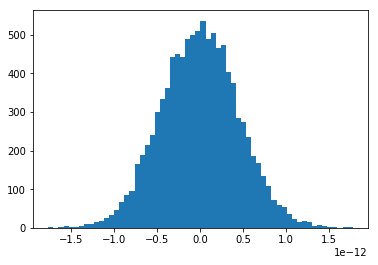

In [43]:
mean=np.array(diff_nir).mean()
sd=np.std(diff_nir)
norm_dis=np.random.normal(0,sd,10000)
plt.hist(norm_dis,bins=60)
#plt.axvline(mean,c='red')

In [45]:
p_v=1-stats.norm.cdf(mean,0,np.std(diff_nir))
p_v

1.0

### The p value obtained is 1.0 which is greater than alpha value 0.025. Hence we cannot reject the null hypothesis. 
### Hence the NIR value is less than or equal to zero. There is not significant increase in NIR value due to the promotions sent to a group of customers.

### Model Building : A model is built and the dataset is fit to the model and classification results are predicted.

In [133]:
# Find the attributes and the class attributes
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
x=train_data[['V1','V2','V3','V4','V5','V6','V7']]
y=train_data['purchase']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)
#clf=DecisionTreeClassifier()
#clf = RandomForestClassifier(max_depth=5, random_state=0,class_weight='balanced_subsample')#
clf=RandomForestClassifier(max_depth=5, random_state=0,class_weight='balanced')
#clf=BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
#accuracy_score(y_test,y_pred)
#print(classification_report(y_test,y_pred))


In [123]:
#promotion_df=[]
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    y_pred=clf.predict(df)
    promotion_df=[]
    for i in y_pred:
        if i==1:
            promotion_df.append('Yes')
        else:
            promotion_df.append('No')
    
    promotion=np.asarray(promotion_df)
    
    return promotion

In [134]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0189.

Your nir with this strategy is 299.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018907145119184593, 299.10000000000014)

In [145]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
clf.fit(x_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [146]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0009.

Your nir with this strategy is -16.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.00089239235517215784, -16.949999999999999)